In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor

In [2]:
# сгенерируем данные
X, Y, coef = make_regression(n_samples=500, n_features=3, n_informative=3, n_targets=1, 
                                      noise=5, coef=True, random_state=2)
display(coef)

array([48.88386483, 96.78882977, 78.61348932])

In [3]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

In [4]:
class Leaf:
        
    def __init__(self, x, y):
        self.data = x
        self.targets = y
        self.prediction = y.mean()

In [5]:
def calc_mse(y, y_pred):
    res = np.mean((y - y_pred)**2)
    return res    

In [6]:
def gain(left_targets, right_targets, root_criterion, criterion):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_targets.shape[0]) / (left_targets.shape[0] + right_targets.shape[0])
    
    return root_criterion - p * criterion(left_targets) - (1 - p) * criterion(right_targets)

In [7]:
def split(data, targets, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_targets = targets[left]
    false_targets = targets[right]
        
    return true_data, false_data, true_targets, false_targets

In [8]:
# Нахождение наилучшего разбиения

def find_best_split(data, targets):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 3
    
    #изменения
    root_std = np.std(targets)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_targets, false_targets = split(data, targets, index, t)
#              пропускаем разбиения, в которых в узле остается менее 3 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_targets, false_targets, root_std, np.std)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [9]:
import time
# Построение дерева с помощью рекурсивной функции

def build_tree(data, targets):

    gain, t, index = find_best_split(data, targets)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, targets)

    true_data, false_data, true_targets, false_targets = split(data, targets, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_targets)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_targets)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [10]:
def predict_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return predict_object(obj, node.true_branch)
    else:
        return predict_object(obj, node.false_branch)

In [11]:
def predict(data, tree):
    
    targets = []
    for obj in data:
        prediction = predict_object(obj, tree)
        targets.append(prediction)
    return targets

In [12]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_y, test_y = train_test_split(X, Y, test_size=0.3, random_state=1)

In [13]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_y)

In [14]:
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1 <= 0.16544826970844606
--> True:
  Индекс 2 <= -0.07663956399736893
  --> True:
    Индекс 2 <= -2.0534471055257284
    --> True:
      Индекс 1 <= -0.6492051595618835
      --> True:
        Прогноз: -329.4413952885717
      --> False:
        Индекс 0 <= -0.9005003138910339
        --> True:
          Прогноз: -262.76094112019473
        --> False:
          Прогноз: -188.6384200008203
    --> False:
      Индекс 1 <= -0.5301394082656447
      --> True:
        Индекс 1 <= -1.9038211429429313
        --> True:
          Индекс 0 <= 0.8875887934002106
          --> True:
            Прогноз: -221.6044114022782
          --> False:
            Прогноз: -199.13111447081644
        --> False:
          Индекс 0 <= -0.050866672635910916
          --> True:
            Индекс 2 <= -0.44690427050504
            --> True:
              Индекс 0 <= -0.5686120029765696
              --> True:
                Прогноз: -216.2223121441068
              --> False:
                Прогноз:

In [15]:
train_answers = predict(train_data, my_tree)

In [16]:
test_answers = predict(test_data, my_tree)

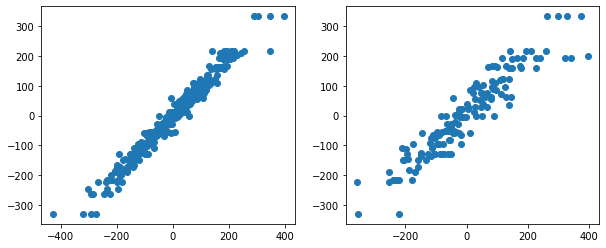

In [17]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(train_y, train_answers)
plt.subplot(122)
plt.scatter(test_y, test_answers)
plt.show()

In [18]:
print(calc_mse(train_y, train_answers), calc_mse(test_y, test_answers))

482.1631623372076 2508.040564324734


Дерево получилось переобученным. Но подгонять параметры и реализовывать разные критерии останова буду в следующий раз ).

### Использование "дерева, вырощенного профессионалами" )
(но без подгонки параметров ))

In [19]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 min_samples_leaf=3,
#                                  max_depth=8,
                                 random_state=42)
dt_model.fit(train_data, train_y)

DecisionTreeRegressor(min_samples_leaf=3, random_state=42)

In [20]:
y_train_preds = dt_model.predict(train_data)

In [21]:
y_test_preds = dt_model.predict(test_data)

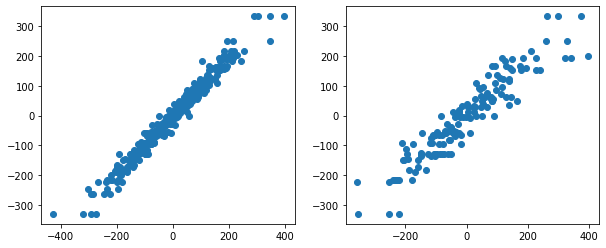

In [22]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(train_y, y_train_preds)
plt.subplot(122)
plt.scatter(test_y, y_test_preds)
plt.show()

In [23]:
print(calc_mse(train_y, y_train_preds), calc_mse(test_y, y_test_preds))

451.6577157368256 2501.9312938735825
